In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from qr_decomposition.decomposition import projection_matrix, qr_decomposition
from qr_decomposition.sentiment.inference import predict, predict_embedding
from qr_decomposition.utils import resolve_path

In [3]:
dataset_path = resolve_path("dataset/imdb_reviews.parquet")
train_df = duckdb.sql(f"SELECT * FROM '{dataset_path}' WHERE split = 'train'").to_df()
val_df = duckdb.sql(f"SELECT * FROM '{dataset_path}' WHERE split = 'val'").to_df()

len(train_df), len(val_df)

(39899, 10101)

In [4]:
def print_pca_stats(pca_data):
    for i in range(2):  # for first two PCs
        print(f"\nPC{i + 1} Statistics:")
        print(f"Mean: {np.mean(pca_data[:, i]):.3f}")
        print(f"Std: {np.std(pca_data[:, i]):.3f}")
        print(f"Min: {np.min(pca_data[:, i]):.3f}")
        print(f"Max: {np.max(pca_data[:, i]):.3f}")
        print(f"25th percentile: {np.percentile(pca_data[:, i], 25):.3f}")
        print(f"Median: {np.median(pca_data[:, i]):.3f}")
        print(f"75th percentile: {np.percentile(pca_data[:, i], 75):.3f}")

In [5]:
val_X = val_df["embeddings"]
val_X = np.array([np.array(emb) for emb in val_X])
val_X_labels = val_df["sentiment"]
val_X.shape

(10101, 1536)

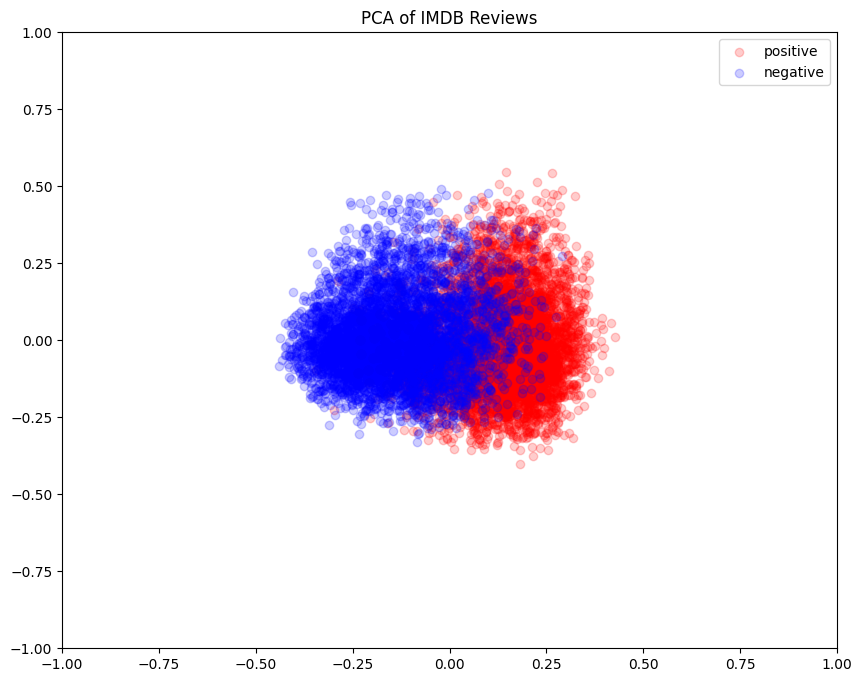

In [6]:
pca = PCA(n_components=2)
val_X_pca = pca.fit_transform(val_X)

# Create boolean masks for each class
positive_mask = np.array([label == "positive" for label in val_X_labels])
negative_mask = ~positive_mask

plt.figure(figsize=(10, 8))
# Plot each class separately
plt.scatter(
    val_X_pca[positive_mask, 0], val_X_pca[positive_mask, 1], c="red", alpha=0.2, label="positive"
)
plt.scatter(
    val_X_pca[negative_mask, 0], val_X_pca[negative_mask, 1], c="blue", alpha=0.2, label="negative"
)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.legend()
plt.title("PCA of IMDB Reviews")
plt.show()

In [7]:
print_pca_stats(val_X_pca)


PC1 Statistics:
Mean: 0.000
Std: 0.183
Min: -0.439
Max: 0.426
25th percentile: -0.149
Median: 0.014
75th percentile: 0.153

PC2 Statistics:
Mean: 0.000
Std: 0.148
Min: -0.400
Max: 0.547
25th percentile: -0.105
Median: -0.016
75th percentile: 0.089


In [8]:
positive_train_df = train_df[train_df["sentiment"] == "positive"]
negative_train_df = train_df[train_df["sentiment"] == "negative"]
len(positive_train_df), len(negative_train_df)

(20022, 19877)

In [9]:
emb_pos = np.array([np.array(emb) for emb in positive_train_df["embeddings"]])
emb_neg = np.array([np.array(emb) for emb in negative_train_df["embeddings"]])

emb_all = np.concatenate([emb_pos, emb_neg])
emb_pos.shape, emb_neg.shape, emb_all.shape

((20022, 1536), (19877, 1536), (39899, 1536))

In [19]:
k = 1500
Q_all, R_all = np.linalg.qr(emb_all.T)
Q_review = Q_all[:, :k]  # Shape: (d, k)
Q_review.shape

(1536, 1500)

In [20]:
def remove_common_component(q, Q_common):
    # Project q onto the common review subspace
    proj = Q_common @ (Q_common.T @ q)
    return q - proj


Q_pos, R_pos = qr_decomposition(emb_pos)
Q_pos_sent_res = np.array([remove_common_component(q, Q_review) for q in Q_pos.T]).T

In [21]:
Q_sentiment, R_sentiment = np.linalg.qr(Q_pos_sent_res)
v = emb_pos[0]  # Example positive review embedding, shape: (d,)
v_sentiment = v @ Q_sentiment @ Q_sentiment.T

orthogonality = [np.dot(v_sentiment, q) for q in Q_review.T]
orthogonality = np.sum(orthogonality) / len(orthogonality)
print("Dot products with Q_review basis (should be near 0):", orthogonality)

v_common = v @ Q_review @ Q_review.T
v_reconstructed = v_common + v_sentiment
reconstruction_error = np.linalg.norm(v - v_reconstructed)
print("Reconstruction error:", reconstruction_error)

Dot products with Q_review basis (should be near 0): 0.0006666666765921363
Reconstruction error: 1.000000014888195


In [22]:
# remove the projected subspace from the validation data
lambda_val = 0.5
val_X_proj_pca_removed = val_X - lambda_val * (val_X @ Q_sentiment @ Q_sentiment.T)
val_X_proj_pca_removed.shape

(10101, 1536)

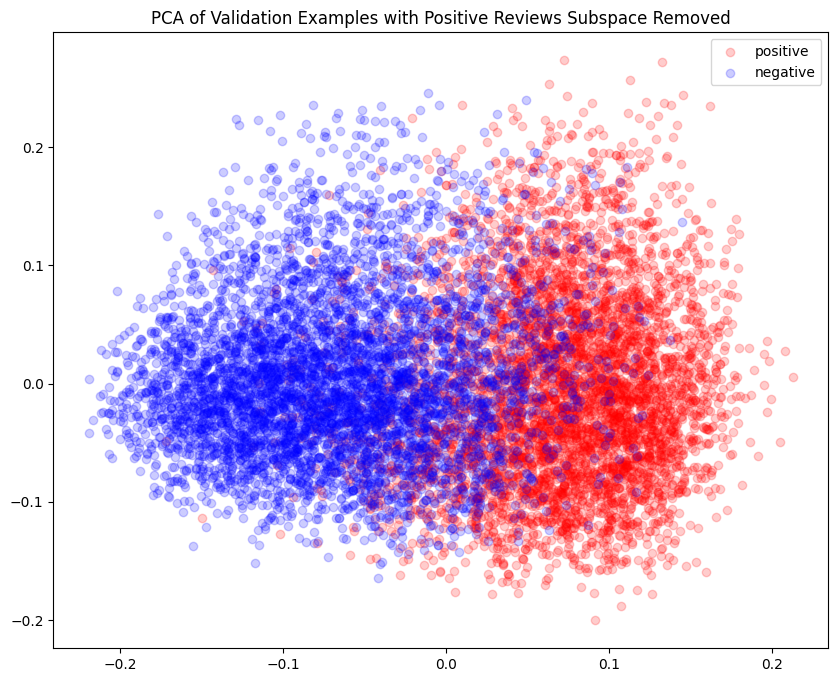

In [23]:
pca = PCA(n_components=2)
val_X_proj_pca_removed_pca = pca.fit_transform(val_X_proj_pca_removed)

# Create boolean masks for each class
positive_mask = np.array([label == "positive" for label in val_X_labels])
negative_mask = ~positive_mask

plt.figure(figsize=(10, 8))
# Plot each class separately
plt.scatter(
    val_X_proj_pca_removed_pca[positive_mask, 0],
    val_X_proj_pca_removed_pca[positive_mask, 1],
    c="red",
    alpha=0.2,
    label="positive",
)
plt.scatter(
    val_X_proj_pca_removed_pca[negative_mask, 0],
    val_X_proj_pca_removed_pca[negative_mask, 1],
    c="blue",
    alpha=0.2,
    label="negative",
)
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)
plt.legend()
plt.title("PCA of Validation Examples with Positive Reviews Subspace Removed")
plt.show()

In [24]:
print_pca_stats(val_X_proj_pca_removed_pca)


PC1 Statistics:
Mean: 0.000
Std: 0.091
Min: -0.219
Max: 0.213
25th percentile: -0.075
Median: 0.007
75th percentile: 0.076

PC2 Statistics:
Mean: 0.000
Std: 0.074
Min: -0.200
Max: 0.273
25th percentile: -0.053
Median: -0.008
75th percentile: 0.045


In [25]:
val_X_predictions = predict_embedding(val_X)
val_X_proj_pca_removed_predictions = predict_embedding(val_X_proj_pca_removed)
len(val_X_proj_pca_removed_predictions), len(val_X_predictions)

(10101, 10101)

In [26]:
val_X_predictions[0], val_X_proj_pca_removed_predictions[0]

({'negative': 6.1862483562435955e-06, 'positive': 0.9999938011169434},
 {'negative': 0.0015271373558789492, 'positive': 0.9984728693962097})

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


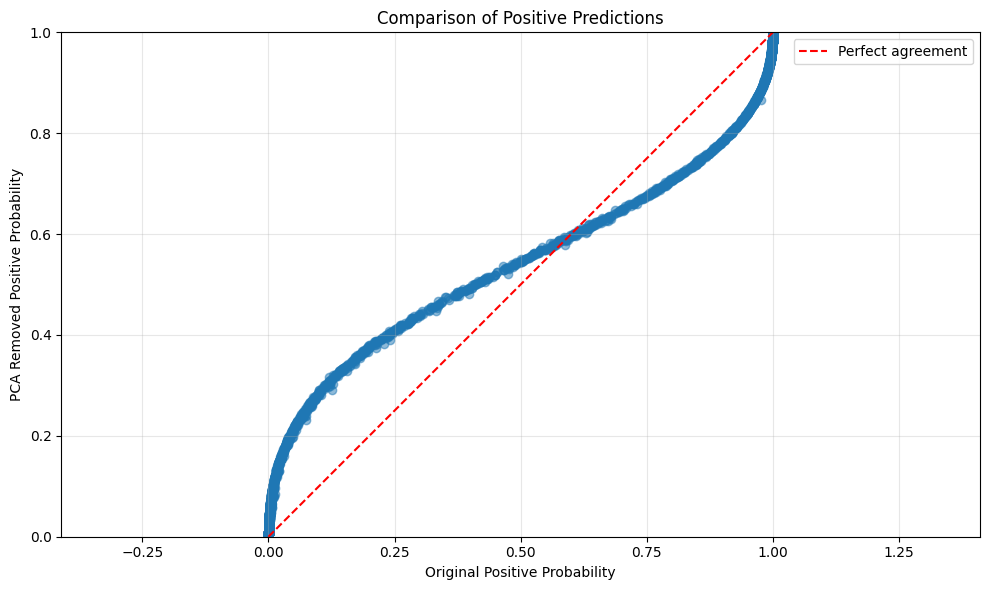

In [27]:
threshold = 0.8
# Extract positive probabilities
pos_prob_original = [pred["positive"] for pred in val_X_predictions]
pos_prob_pca_removed = [pred["positive"] for pred in val_X_proj_pca_removed_predictions]

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pos_prob_original, pos_prob_pca_removed, alpha=0.5)

# Add diagonal reference line
plt.plot([0, 1], [0, 1], "r--", label="Perfect agreement")

# Add labels and title
plt.xlabel("Original Positive Probability")
plt.ylabel("PCA Removed Positive Probability")
plt.title("Comparison of Positive Predictions")

# Add grid
plt.grid(True, alpha=0.3)

# Set equal aspect ratio and limits
plt.axis("equal")
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend()
plt.tight_layout()
plt.show()